## Bibliotecas necessárias

In [24]:
# Importação de Bibliotecas Necessárias
import numpy as np
import pandas as pd
import librosa
import librosa.display
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D,MaxPooling1D,LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from imblearn.over_sampling import SMOTE
import soundata
import tensorflow as tf
import os
import librosa
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.regularizers import l1_l2

## Extração de features e download dos sons

In [4]:
dfclass = pd.read_csv(r'UrbanSound8K.csv')
dfclass.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
FOLDS_PATH = "../UrbanSound8K/audio/"

In [6]:
def load_fold_data(features_file, labels_file, label_encoder):
    features = pd.read_csv(features_file).values
    labels = pd.read_csv(labels_file)['0']
    encoded_labels = label_encoder.transform(labels)
    return features, encoded_labels

In [7]:
def create_label_mapping(folds_path, n_folds):
    all_labels = set()
    for fold_number in range(1, n_folds + 1):
        labels_file = f'csv/labelsfold{fold_number}.csv'
        df_labels = pd.read_csv(labels_file)
        all_labels.update(df_labels['0'].unique())
    
    label_encoder = LabelEncoder()
    label_encoder.fit(list(all_labels))
    return label_encoder


In [90]:
def load_data(FOLDS_PATH):
    features = []
    labels = []
    
    folds = [fold for fold in os.listdir(FOLDS_PATH) if "fold" in fold]
    for fold in folds:
        audio_files = librosa.util.find_files(FOLDS_PATH+"/"+fold)
        features = []
        labels = []
        for audio_file_path in audio_files:

            # Carregar o arquivo de áudio
            audio_data, sample_rate = librosa.load(audio_file_path,sr=44100)
            audio_data = librosa.util.fix_length(audio_data, size=int(4 * 44100))
            # Extrair características (exemplo: MFCCs)

            mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
            mfccs_mean = np.mean(mfccs.T, axis=0)  # Média dos MFCCs ao longo do tempo


            # Extração de Chroma
            chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
            chroma_mean = np.mean(chroma, axis=1)

            # Extração de Spectral Contrast
            spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
            spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

            # Extração de Zero Crossing Rate
            zero_crossing_rate = librosa.feature.zero_crossing_rate(audio_data)
            zero_crossing_rate_mean = np.mean(zero_crossing_rate)

            # Combinando todas as características
            combined_features = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, zero_crossing_rate_mean))

            # Adicionar características à lista
            features.append(combined_features)

            audio_file = audio_file_path.split("/")[-1]
            label=dfclass.loc[dfclass['slice_file_name'] == audio_file, 'class'].iloc[0]
            # Adicionar o rótulo à lista (modificar conforme necessário)
           
            labels.append(label)

        df = pd.DataFrame(features)
        df.to_csv(f"csv/features{fold}.csv")
        dl= pd.DataFrame(labels)
        dl.to_csv(f"csv/labels{fold}.csv")
        print(f"{fold} finished")           
 


load_data(FOLDS_PATH)

/home/guilherme/.local/lib/python3.8/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


fold1 finished
fold10 finished
fold2 finished
fold3 finished
fold4 finished
fold5 finished
fold6 finished
fold7 finished
fold8 finished
fold9 finished


## Vamos observar cada fold em particular

In [57]:
def analyze_fold(fold_number):
    # Carregar características e rótulos do fold específico
    features_path = f"csv/featuresfold{fold_number}.csv"
    labels_path = f"csv/labelsfold{fold_number}.csv"
    df_labels = pd.read_csv(labels_path)

    # Adicionar os rótulos ao DataFrame das características
    

    # Observar rótulos únicos
    unique_labels = df_labels['0'].unique()
    print(f"Etiquetas únicas no conjunto de dados do fold {fold_number}: {unique_labels}\n")

for i in range(1,11):
    analyze_fold(i)

Etiquetas únicas no conjunto de dados do fold 1: ['dog_bark' 'gun_shot' 'jackhammer' 'engine_idling' 'children_playing'
 'siren' 'street_music' 'air_conditioner' 'drilling' 'car_horn']

Etiquetas únicas no conjunto de dados do fold 2: ['dog_bark' 'engine_idling' 'siren' 'drilling' 'children_playing'
 'air_conditioner' 'car_horn' 'street_music' 'gun_shot' 'jackhammer']

Etiquetas únicas no conjunto de dados do fold 3: ['dog_bark' 'drilling' 'engine_idling' 'gun_shot' 'car_horn' 'siren'
 'children_playing' 'air_conditioner' 'street_music' 'jackhammer']

Etiquetas únicas no conjunto de dados do fold 4: ['dog_bark' 'street_music' 'jackhammer' 'siren' 'car_horn' 'engine_idling'
 'drilling' 'gun_shot' 'children_playing' 'air_conditioner']

Etiquetas únicas no conjunto de dados do fold 5: ['dog_bark' 'children_playing' 'air_conditioner' 'jackhammer'
 'street_music' 'engine_idling' 'siren' 'drilling' 'car_horn' 'gun_shot']

Etiquetas únicas no conjunto de dados do fold 6: ['dog_bark' 'children

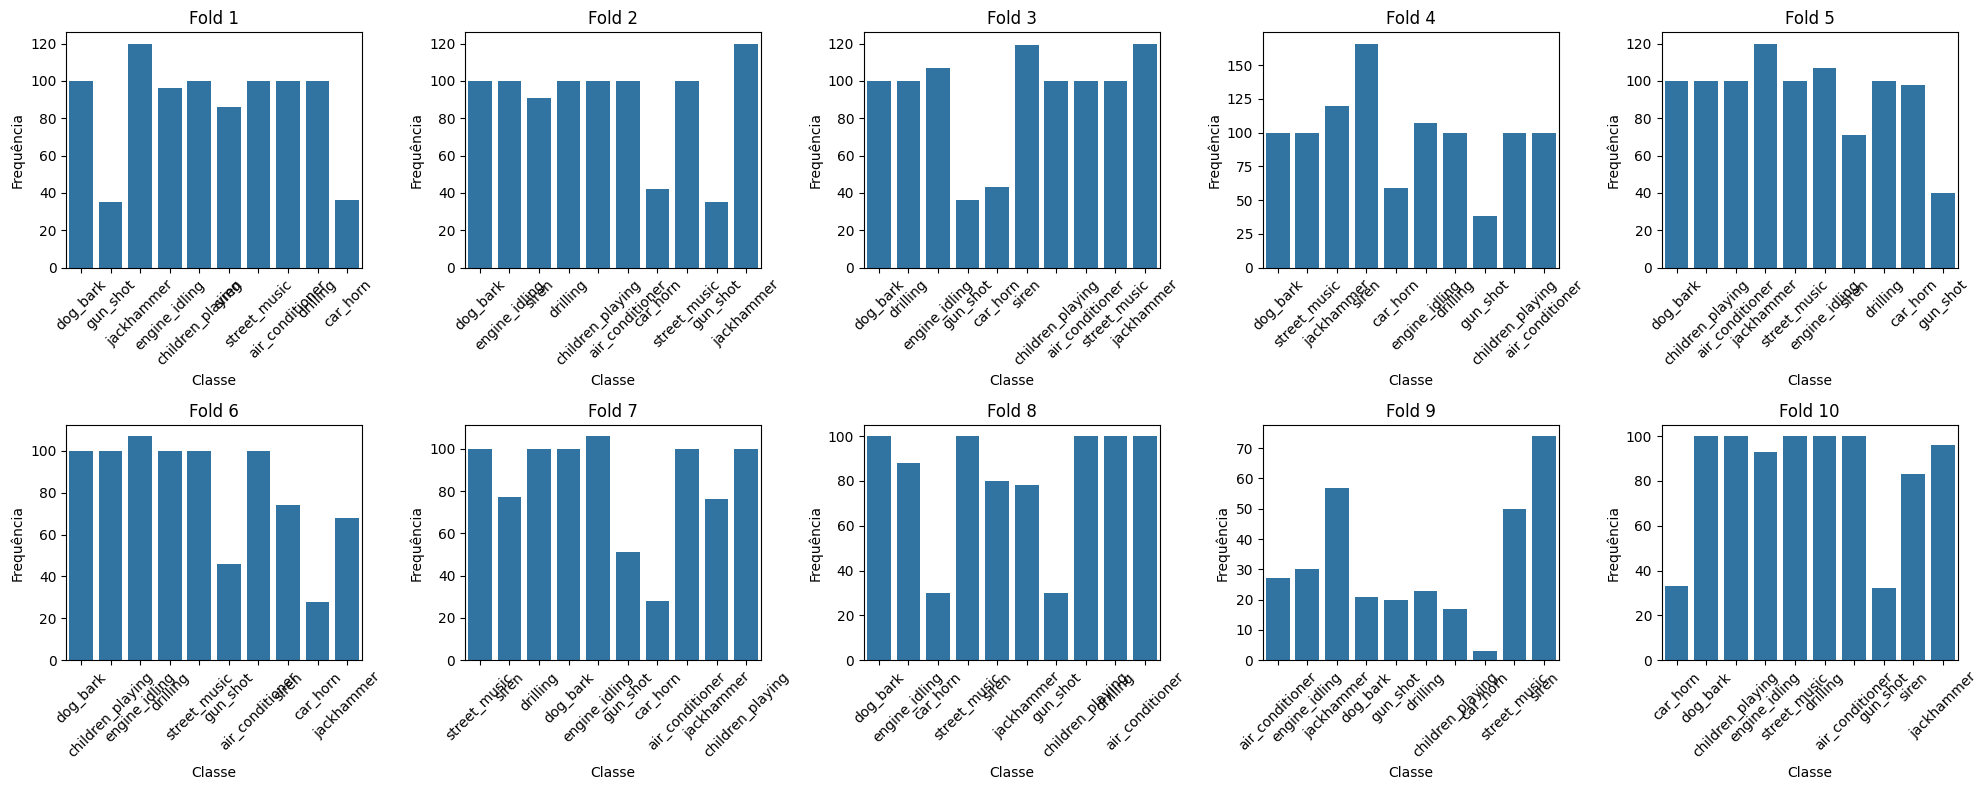

In [66]:
def plot_label_distribution_all_folds(n_folds):
    # Número de linhas e colunas para os subplots
    nrows = 2
    ncols = 5

    # Configurar o layout para os subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))  # Ajuste o tamanho conforme necessário

    for fold_number in range(1, n_folds + 1):
        # Carregar os rótulos do fold específico
        labels_path = f"csv/labelsfold{fold_number}.csv"
        df_labels = pd.read_csv(labels_path)

        # Determinar a posição do subplot
        row = (fold_number - 1) // ncols
        col = (fold_number - 1) % ncols

        # Plotar o gráfico no subplot correspondente
        sns.countplot(x=df_labels['0'], ax=axes[row, col])
        axes[row, col].set_title(f'Fold {fold_number}')
        axes[row, col].set_xlabel('Classe')
        axes[row, col].set_ylabel('Frequência')
        axes[row, col].tick_params(axis='x', rotation=45)

    # Ajustar o layout e exibir a figura
    plt.tight_layout()
    plt.show()

# Exemplo de uso para todos os 10 folds
plot_label_distribution_all_folds(10)

/tmp/ipykernel_11372/664023078.py:24: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max),


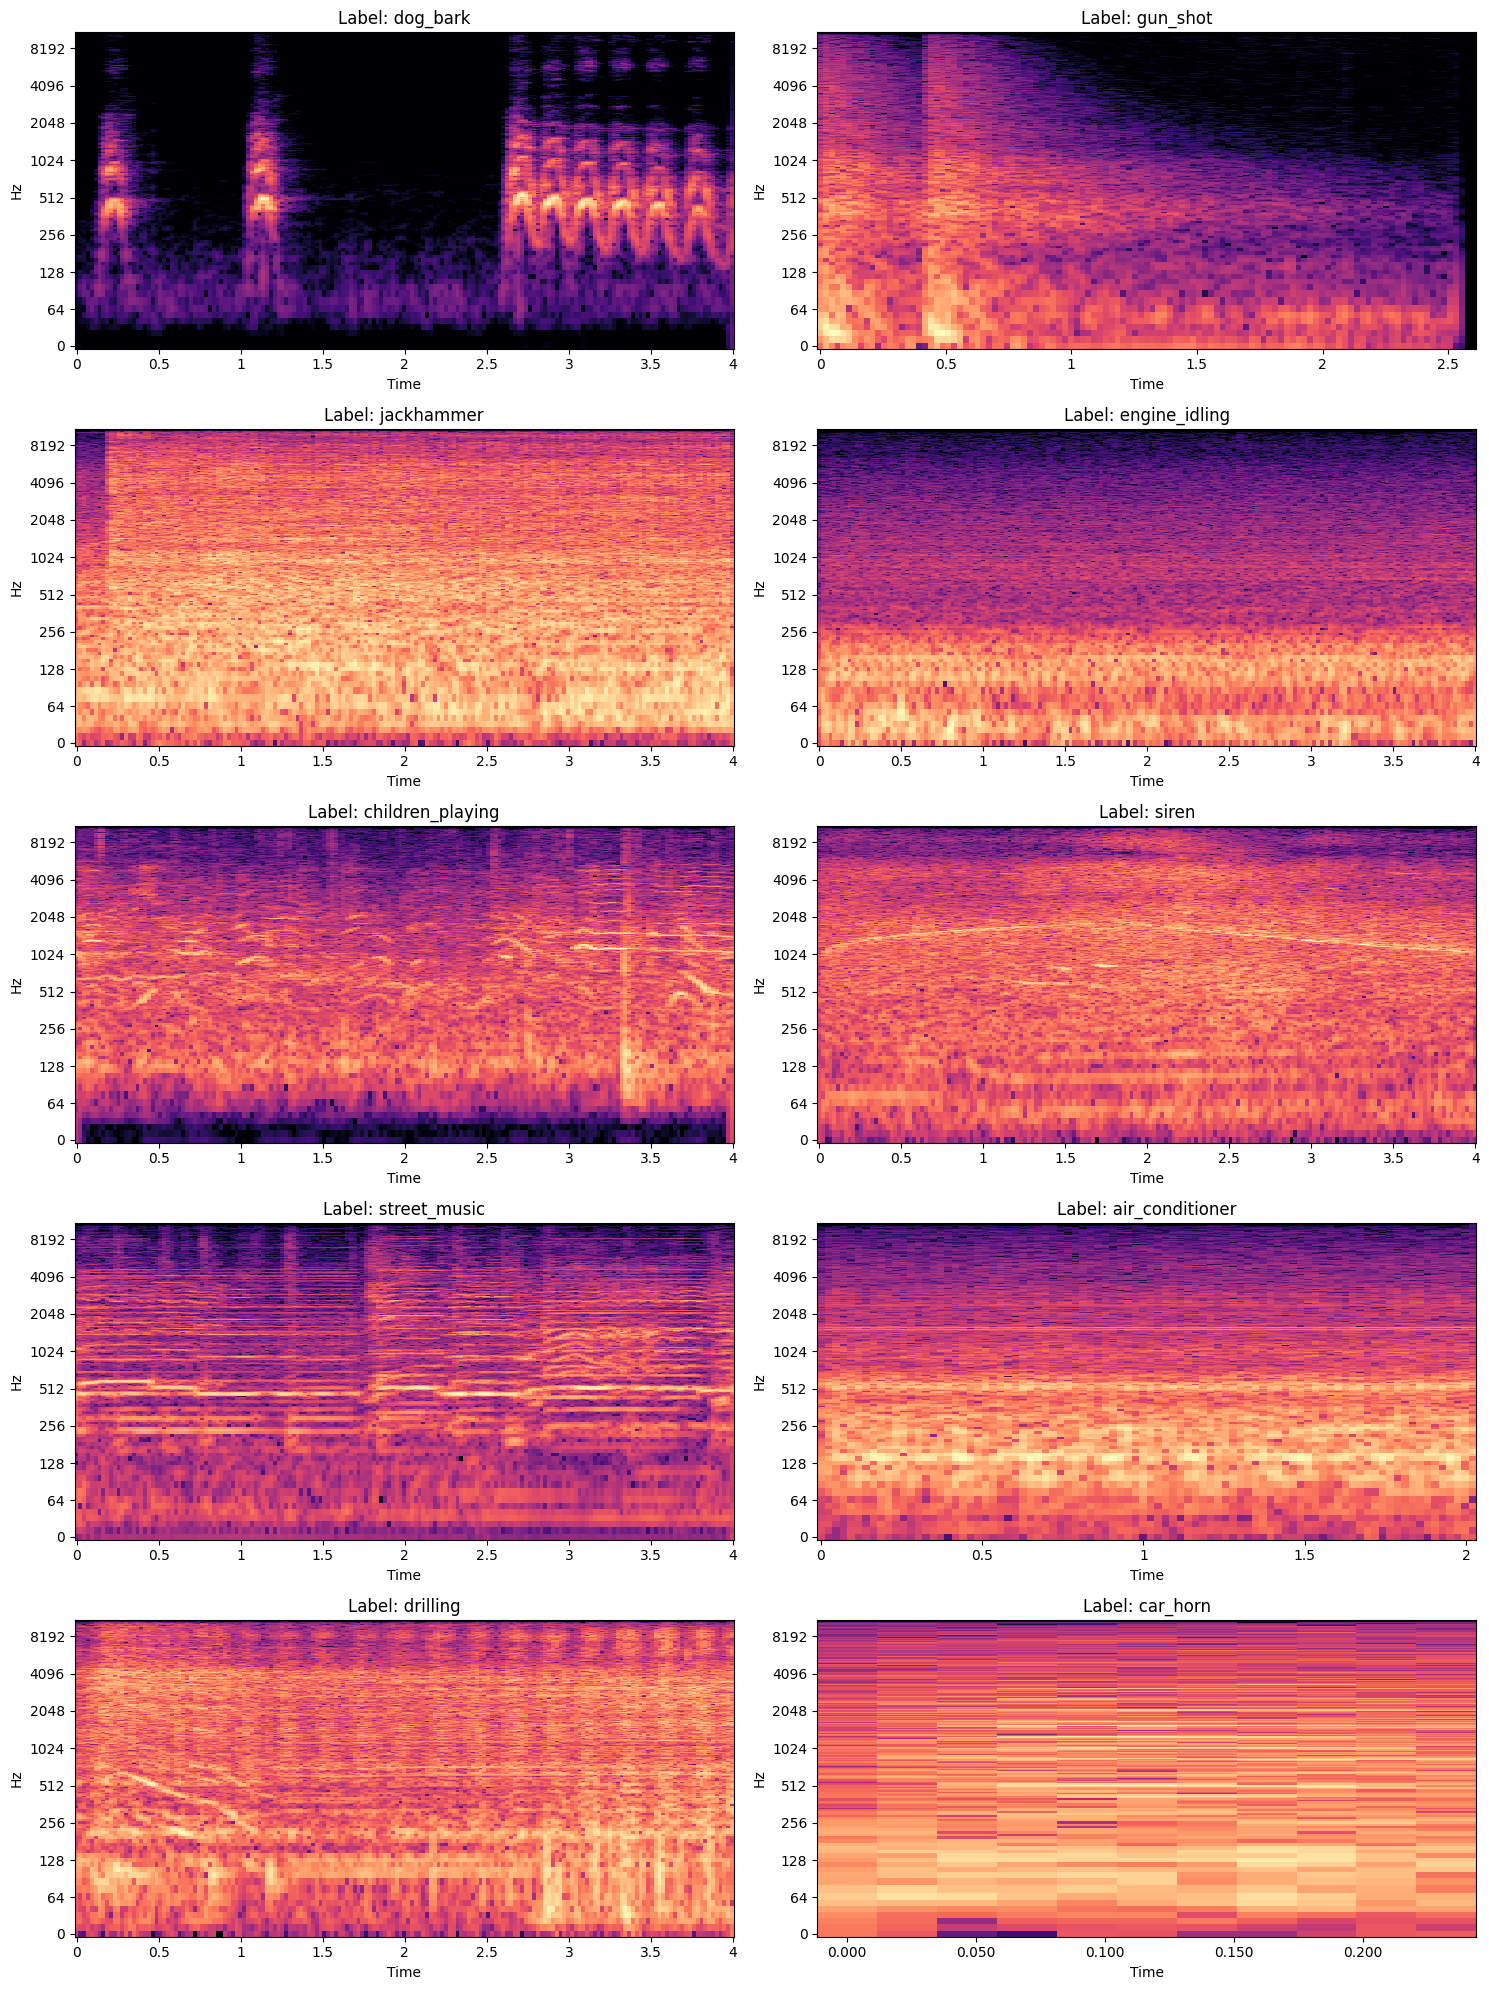

In [71]:
# Preparando o layout para os subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))  #tamanho dos subplots
axes = axes.flatten()  # array unidimensional

processed_labels = set()
label_count = 0

folds = [fold for fold in os.listdir(FOLDS_PATH) if "fold" in fold]
for fold in folds:
    audio_files = librosa.util.find_files(FOLDS_PATH+"/"+fold)
    features = []
    labels = []
    for audio_file_path in audio_files:

        # Carregar o arquivo de áudio
        audio_data, sample_rate = librosa.load(audio_file_path)
        audio_file = audio_file_path.split("/")[-1]
        label=dfclass.loc[dfclass['slice_file_name'] == audio_file, 'class'].iloc[0]

        if label not in processed_labels:
            processed_labels.add(label)

            # Meter grafico no subplot correspondente
            librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max), 
                                     sr=sample_rate, 
                                     x_axis='time', 
                                     y_axis='log', 
                                     ax=axes[label_count])
            axes[label_count].set_title(f'Label: {label}') 
            label_count += 1
            if label_count >= 10:  # Se já tiver os 10 graficos
                break

plt.tight_layout()
plt.show()

## K-Fold Cross Validation

### Para a CNN

In [91]:
def kfold(n_folds,label_encoder):
    accuracies = []
    conf_matrices = []
    all_histories = []
    scaler = StandardScaler()
    for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            features_file = f'csv/featuresfold{fold}.csv'
            labels_file = f'csv/labelsfold{fold}.csv'
            features, encoded_labels = load_fold_data(features_file, labels_file, label_encoder)

            if fold == test_fold:
                X_test, y_test = features, encoded_labels
            else:
                X_train.append(features)
                y_train.append(encoded_labels)

        # Concatenar e preparar os dados de treino
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Conversão para formato categórico
        y_train_categorical = to_categorical(y_train)
        y_test_categorical = to_categorical(y_test)
        
        model = Sequential()
        model.add(Conv1D(32, 3, input_shape=(X_train.shape[1], 1)))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.3))
        model.add(Conv1D(64, 3))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.4))
        model.add(Conv1D(128, 3))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(10, activation='softmax'))

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        hist = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_test, y_test_categorical), callbacks=[early_stopping])

        # Construir, compilar e treinar o modelo
        all_histories.append(hist.history)
        # Avaliação do modelo
        test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_categorical, axis=1)
        
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        conf_matrices.append(conf_mat)
        
        accuracies.append(test_accuracy)
        
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    print("Matriz de Confusão Média:\n", mean_conf_matrix)
    print(f"Acurácia média: {mean_accuracy:.2f}, Desvio padrão: {std_accuracy:.2f}")
    return all_histories, mean_conf_matrix, mean_accuracy, std_accuracy


### Para o MLP

In [28]:
def kfoldmlp(n_folds, label_encoder, num_classes):
    accuracies = []
    conf_matrices = []
    all_histories = []
    scaler = StandardScaler()
    smotess=''

    for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            features_file = f'csv/featuresfold{fold}.csv'
            labels_file = f'csv/labelsfold{fold}.csv'
            features, encoded_labels = load_fold_data(features_file, labels_file, label_encoder)

            if fold == test_fold:
                X_test, y_test = features, encoded_labels
            else:
                X_train.append(features)
                y_train.append(encoded_labels)

        # Concatenar e preparar os dados de treino
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        unique, counts = np.unique(y_train, return_counts=True)
        somtess='sem SMOTE'

        if min(counts) / max(counts) < 0.5 :  # Exemplo de critério, ajuste conforme necessário
            # Aplicar SMOTE
            smote = SMOTE()
            X_train, y_train = smote.fit_resample(X_train, y_train)
            smotess='com SMOTE'
        
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))

        # Normalizar os dados
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Conversão para formato categórico
        y_train_categorical = to_categorical(y_train, num_classes=num_classes)
        y_test_categorical = to_categorical(y_test, num_classes=num_classes)

        modelMLP = Sequential()
        modelMLP.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],),
                        kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
        modelMLP.add(Dropout(0.3))
        modelMLP.add(Dense(128, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
        modelMLP.add(Dense(10, activation='softmax'))

        
        modelMLP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        # Construir, compilar e treinar o modelo
        hist = modelMLP.fit(X_train, y_train_categorical, epochs=50, batch_size=64, validation_data=(X_test, y_test_categorical), callbacks=[early_stopping], verbose=0)
        all_histories.append(hist.history)

        # Avaliação do modelo
        test_loss, test_accuracy = modelMLP.evaluate(X_test, y_test_categorical)
        y_pred = modelMLP.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_categorical, axis=1)
        
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        conf_matrices.append(conf_mat)
        accuracies.append(test_accuracy)
        print(f"Fold {test_fold} completa {smotess}")

    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print("Matriz de Confusão Média:\n", mean_conf_matrix)
    print(f"Acurácia média: {mean_accuracy:.2f}, Desvio padrão: {std_accuracy:.2f}")

    return all_histories, mean_conf_matrix, mean_accuracy, std_accuracy


## Primeiro Modelo Convulsional Neural Network

### Definir a arquitetura:

##### Camadas Conv1D: Duas camadas convolucionais com 64 e 128 filtros, respectivamente, e kernels de tamanho 3. Essas camadas são responsáveis por extrair características relevantes dos dados de áudio.

##### Camadas MaxPooling1D: Seguindo cada camada convolucional, estas camadas reduzem a dimensionalidade dos dados, o que ajuda a diminuir a complexidade computacional e a combater o overfitting.

##### Camada Flatten: Transforma os dados de uma forma multidimensional para um vetor unidimensional, preparando-os para a próxima etapa de processamento.

##### Camada Densa e Dropout: Uma camada densa com 128 neurônios é seguida por uma camada de dropout que ajuda a prevenir o overfitting ao descartar aleatoriamente parte dos sinais.

##### Camada de Saída: Uma camada densa com uma função de ativação 'softmax', utilizada para a classificação multiclasse. O número de neurônios nesta camada corresponde ao número de classes a serem previstas.

### Compilação do Modelo

##### O modelo é compilado com o otimizador 'adam' e a função de perda 'categorical_crossentropy', com 'accuracy' como métrica de desempenho. Este setup é padrão para problemas de classificação multiclasse.

### K-Fold Cross Validation com os folds predefenidos 

In [28]:
n_folds = 10
accuracies = []
conf_matrices = []
all_histories = []

label_encoder = create_label_mapping(FOLDS_PATH, n_folds)

all_histories, mean_conf_matrix, mean_accuracy, std_accuracy=kfold(10,label_encoder)

NameError: name 'kfold' is not defined

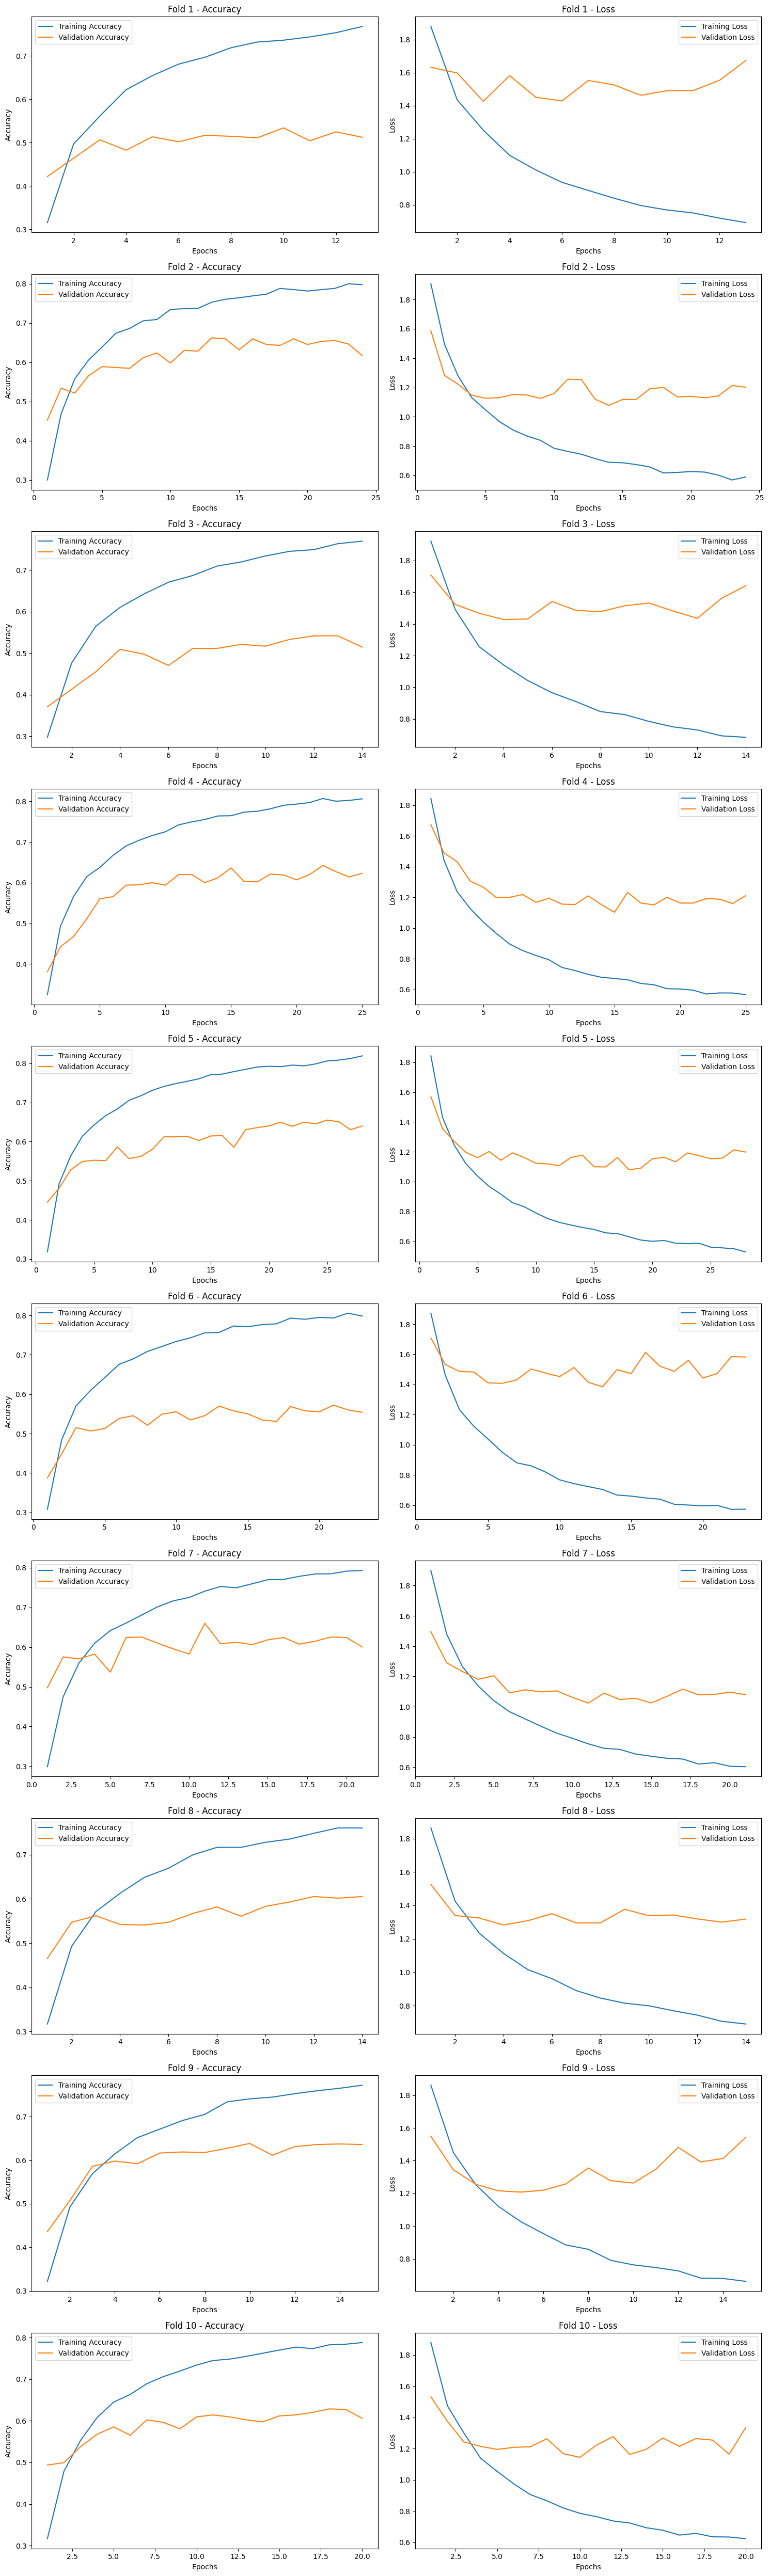

In [94]:
import matplotlib.pyplot as plt

def plot_all_histories(all_histories):
    # Define o número de linhas e colunas para a grade de subplots
    n_rows = 10  # Uma linha para cada fold
    n_cols = 2   # Duas colunas: uma para acurácia e outra para perda

    # Cria uma figura grande para acomodar todos os subplots
    plt.figure(figsize=(15, 50))  # Ajuste o tamanho conforme necessário

    for i, history in enumerate(all_histories):
        epochs = range(1, len(history['accuracy']) + 1)

        # Subplot para acurácia
        plt.subplot(n_rows, n_cols, 2*i + 1)
        plt.plot(epochs, history['accuracy'], label='Training Accuracy')
        plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Fold {i+1} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Subplot para perda
        plt.subplot(n_rows, n_cols, 2*i + 2)
        plt.plot(epochs, history['loss'], label='Training Loss')
        plt.plot(epochs, history['val_loss'], label='Validation Loss')
        plt.title(f'Fold {i+1} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Chamar a função para plotar todos os históricos
plot_all_histories(all_histories)


## Segundo Modelo: Multi-Layer Perceptron

In [16]:
import keras
keras.utils.plot_model(modelMLP, 'MLP.png', show_shapes=True)

NameError: name 'modelMLP' is not defined

In [29]:
n_folds = 10
accuracies = []
conf_matrices = []
all_histories = []

label_encoder = create_label_mapping(FOLDS_PATH, n_folds)
all_histories, mean_conf_matrix, mean_accuracy, std_accuracy=kfoldmlp(n_folds, label_encoder, 10)

28/28 [==============================] - 0s 1ms/step
Fold 1 completa com SMOTE
28/28 [==============================] - 0s 2ms/step
Fold 2 completa com SMOTE
29/29 [==============================] - 0s 1ms/step
Fold 3 completa com SMOTE
31/31 [==============================] - 0s 1ms/step
Fold 4 completa com SMOTE
30/30 [==============================] - 0s 1ms/step
Fold 5 completa com SMOTE
26/26 [==============================] - 0s 1ms/step
Fold 6 completa com SMOTE
27/27 [==============================] - 0s 1ms/step
Fold 7 completa com SMOTE
26/26 [==============================] - 0s 1ms/step
Fold 8 completa com SMOTE
26/26 [==============================] - 0s 1ms/step
Fold 9 completa com SMOTE
27/27 [==============================] - 0s 1ms/step
Fold 10 completa com SMOTE
Matriz de Confusão Média:
 [[53.9  1.6  4.5  2.1  7.6 15.2  0.1  6.   0.2  8.8]
 [ 1.4 34.4  0.3  1.   2.9  0.3  0.9  0.6  0.3  0.8]
 [ 3.1  0.2 74.   5.1  2.1  1.8  0.3  0.4  2.5 10.5]
 [ 1.9  2.3  8.2 73.3  

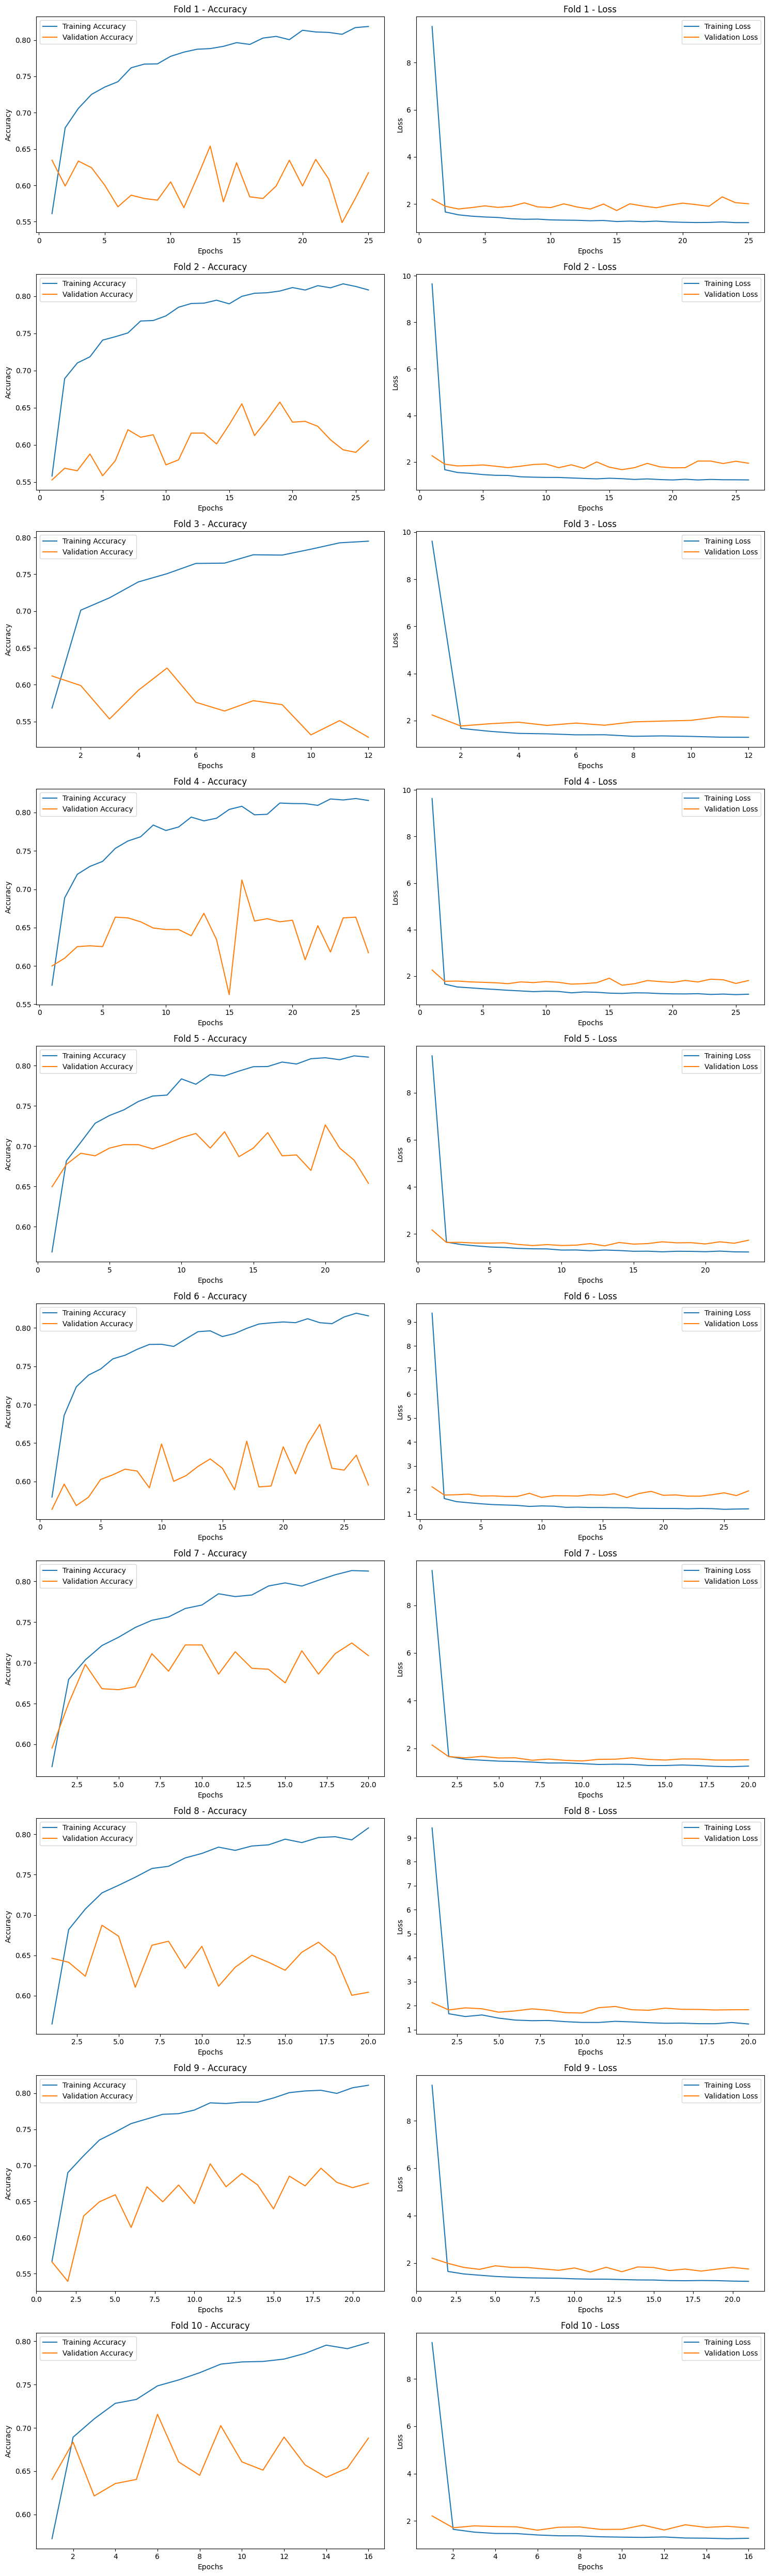

In [30]:
import matplotlib.pyplot as plt

def plot_all_histories(all_histories):
    # Define o número de linhas e colunas para a grade de subplots
    n_rows = 10  # Uma linha para cada fold
    n_cols = 2   # Duas colunas: uma para acurácia e outra para perda

    # Cria uma figura grande para acomodar todos os subplots
    plt.figure(figsize=(15, 50))  # Ajuste o tamanho conforme necessário

    for i, history in enumerate(all_histories):
        epochs = range(1, len(history['categorical_accuracy']) + 1)

        # Subplot para acurácia
        plt.subplot(n_rows, n_cols, 2*i + 1)
        plt.plot(epochs, history['categorical_accuracy'], label='Training Accuracy')
        plt.plot(epochs, history['val_categorical_accuracy'], label='Validation Accuracy')
        plt.title(f'Fold {i+1} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Subplot para perda
        plt.subplot(n_rows, n_cols, 2*i + 2)
        plt.plot(epochs, history['loss'], label='Training Loss')
        plt.plot(epochs, history['val_loss'], label='Validation Loss')
        plt.title(f'Fold {i+1} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Chamar a função para plotar todos os históricos
plot_all_histories(all_histories)


# Daqui para baixo é brincando e vendo

In [189]:
from tensorflow.keras import layers, models
chromagram_shape = (12, 321, 1)

chromagram_input = keras.Input(shape=chromagram_shape, name='chromagram_input')

chromalayer = layers.Conv2D(64, (4,4), activation='relu')(chromagram_input)
# chromalayer = layers.Conv2D(64, (3,3), activation='relu')(chromalayer)
chromalayer = layers.MaxPooling2D((2,2))(chromalayer)
chromalayer = layers.Dropout(0.2)(chromalayer)
# chromalayer = layers.Conv2D(64, (3,3), activation='relu')(chromalayer)
chromalayer = layers.Flatten()(chromalayer)

mel_shape = (128, 321, 1)

mel_spectogram_input = keras.Input(shape=mel_shape, name='mel_spectogram_input')

mellayer = layers.Conv2D(64, (3,3), activation='relu')(mel_spectogram_input)
mellayer = layers.MaxPooling2D((2,2))(mellayer)
mellayer = layers.Dropout(0.3)(mellayer)
mellayer = layers.Conv2D(32, (3,3), activation='relu')(mellayer)
mellayer = layers.MaxPooling2D((2,2))(mellayer)
mellayer = layers.Dropout(0.3)(mellayer)
mellayer = layers.Flatten()(mellayer)

tempogram_shape = (508, 322, 1)

fourier_tempogram = keras.Input(shape=tempogram_shape, name='fourier_tempogram')

fourierlayer = layers.Conv2D(128, (3,3), activation='relu')(fourier_tempogram)
fourierlayer = layers.MaxPooling2D((3,3))(fourierlayer)
fourierlayer = layers.Conv2D(64, (3,3), activation='relu')(fourierlayer)
fourierlayer = layers.MaxPooling2D((3,3))(fourierlayer)	
fourierlayer = layers.Dropout(0.3)(fourierlayer)
fourierlayer = layers.Conv2D(32, (3,3), activation='relu')(fourierlayer)
# fourierlayer = layers.Dropout(0.4)(fourierlayer)
# fourierlayer = layers.Conv2D(64, (3,3), activation='relu')(fourierlayer)
fourierlayer = layers.Flatten()(fourierlayer)

features_1d_shape = (321, 4)

features_1d = keras.Input(shape=features_1d_shape, name='features_1d')

featureslayer = layers.Conv1D(32, 3, activation='relu')(features_1d)
featureslayer = layers.MaxPooling1D(2)(featureslayer)
featureslayer = layers.Conv1D(64, 3, activation='relu')(featureslayer)
featureslayer = layers.MaxPooling1D(2)(featureslayer)
featureslayer = layers.Dropout(0.2)(featureslayer)
featureslayer = layers.Conv1D(64, 3, activation='relu')(featureslayer)
featureslayer = layers.Flatten()(featureslayer)

combined = layers.concatenate([chromalayer, fourierlayer, mellayer, featureslayer])
combined = layers.Dense(128, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
combined = layers.Dense(64, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
combined = layers.Dense(32, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
combined = layers.Dense(10, activation='softmax')(combined)

model = keras.Model(inputs=[chromagram_input, mel_spectogram_input, fourier_tempogram, features_1d], outputs=combined)

model.compile(optimizer='', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

2023-11-26 23:18:01.462247: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 89456640 exceeds 10% of free system memory.
2023-11-26 23:18:01.480420: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 89456640 exceeds 10% of free system memory.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fourier_tempogram (InputLayer)  [(None, 508, 322, 1  0          []                               
                                )]                                                                
                                                                                                  
 mel_spectogram_input (InputLay  [(None, 128, 321, 1  0          []                               
 er)                            )]                                                                
                                                                                                  
 features_1d (InputLayer)       [(None, 321, 4)]     0           []                               
                                                                                            

 dense_51 (Dense)               (None, 32)           2080        ['dropout_41[0][0]']             
                                                                                                  
 dropout_42 (Dropout)           (None, 32)           0           ['dense_51[0][0]']               
                                                                                                  
 dense_52 (Dense)               (None, 10)           330         ['dropout_42[0][0]']             
                                                                                                  
Total params: 22,507,658
Trainable params: 22,507,658
Non-trainable params: 0
__________________________________________________________________________________________________


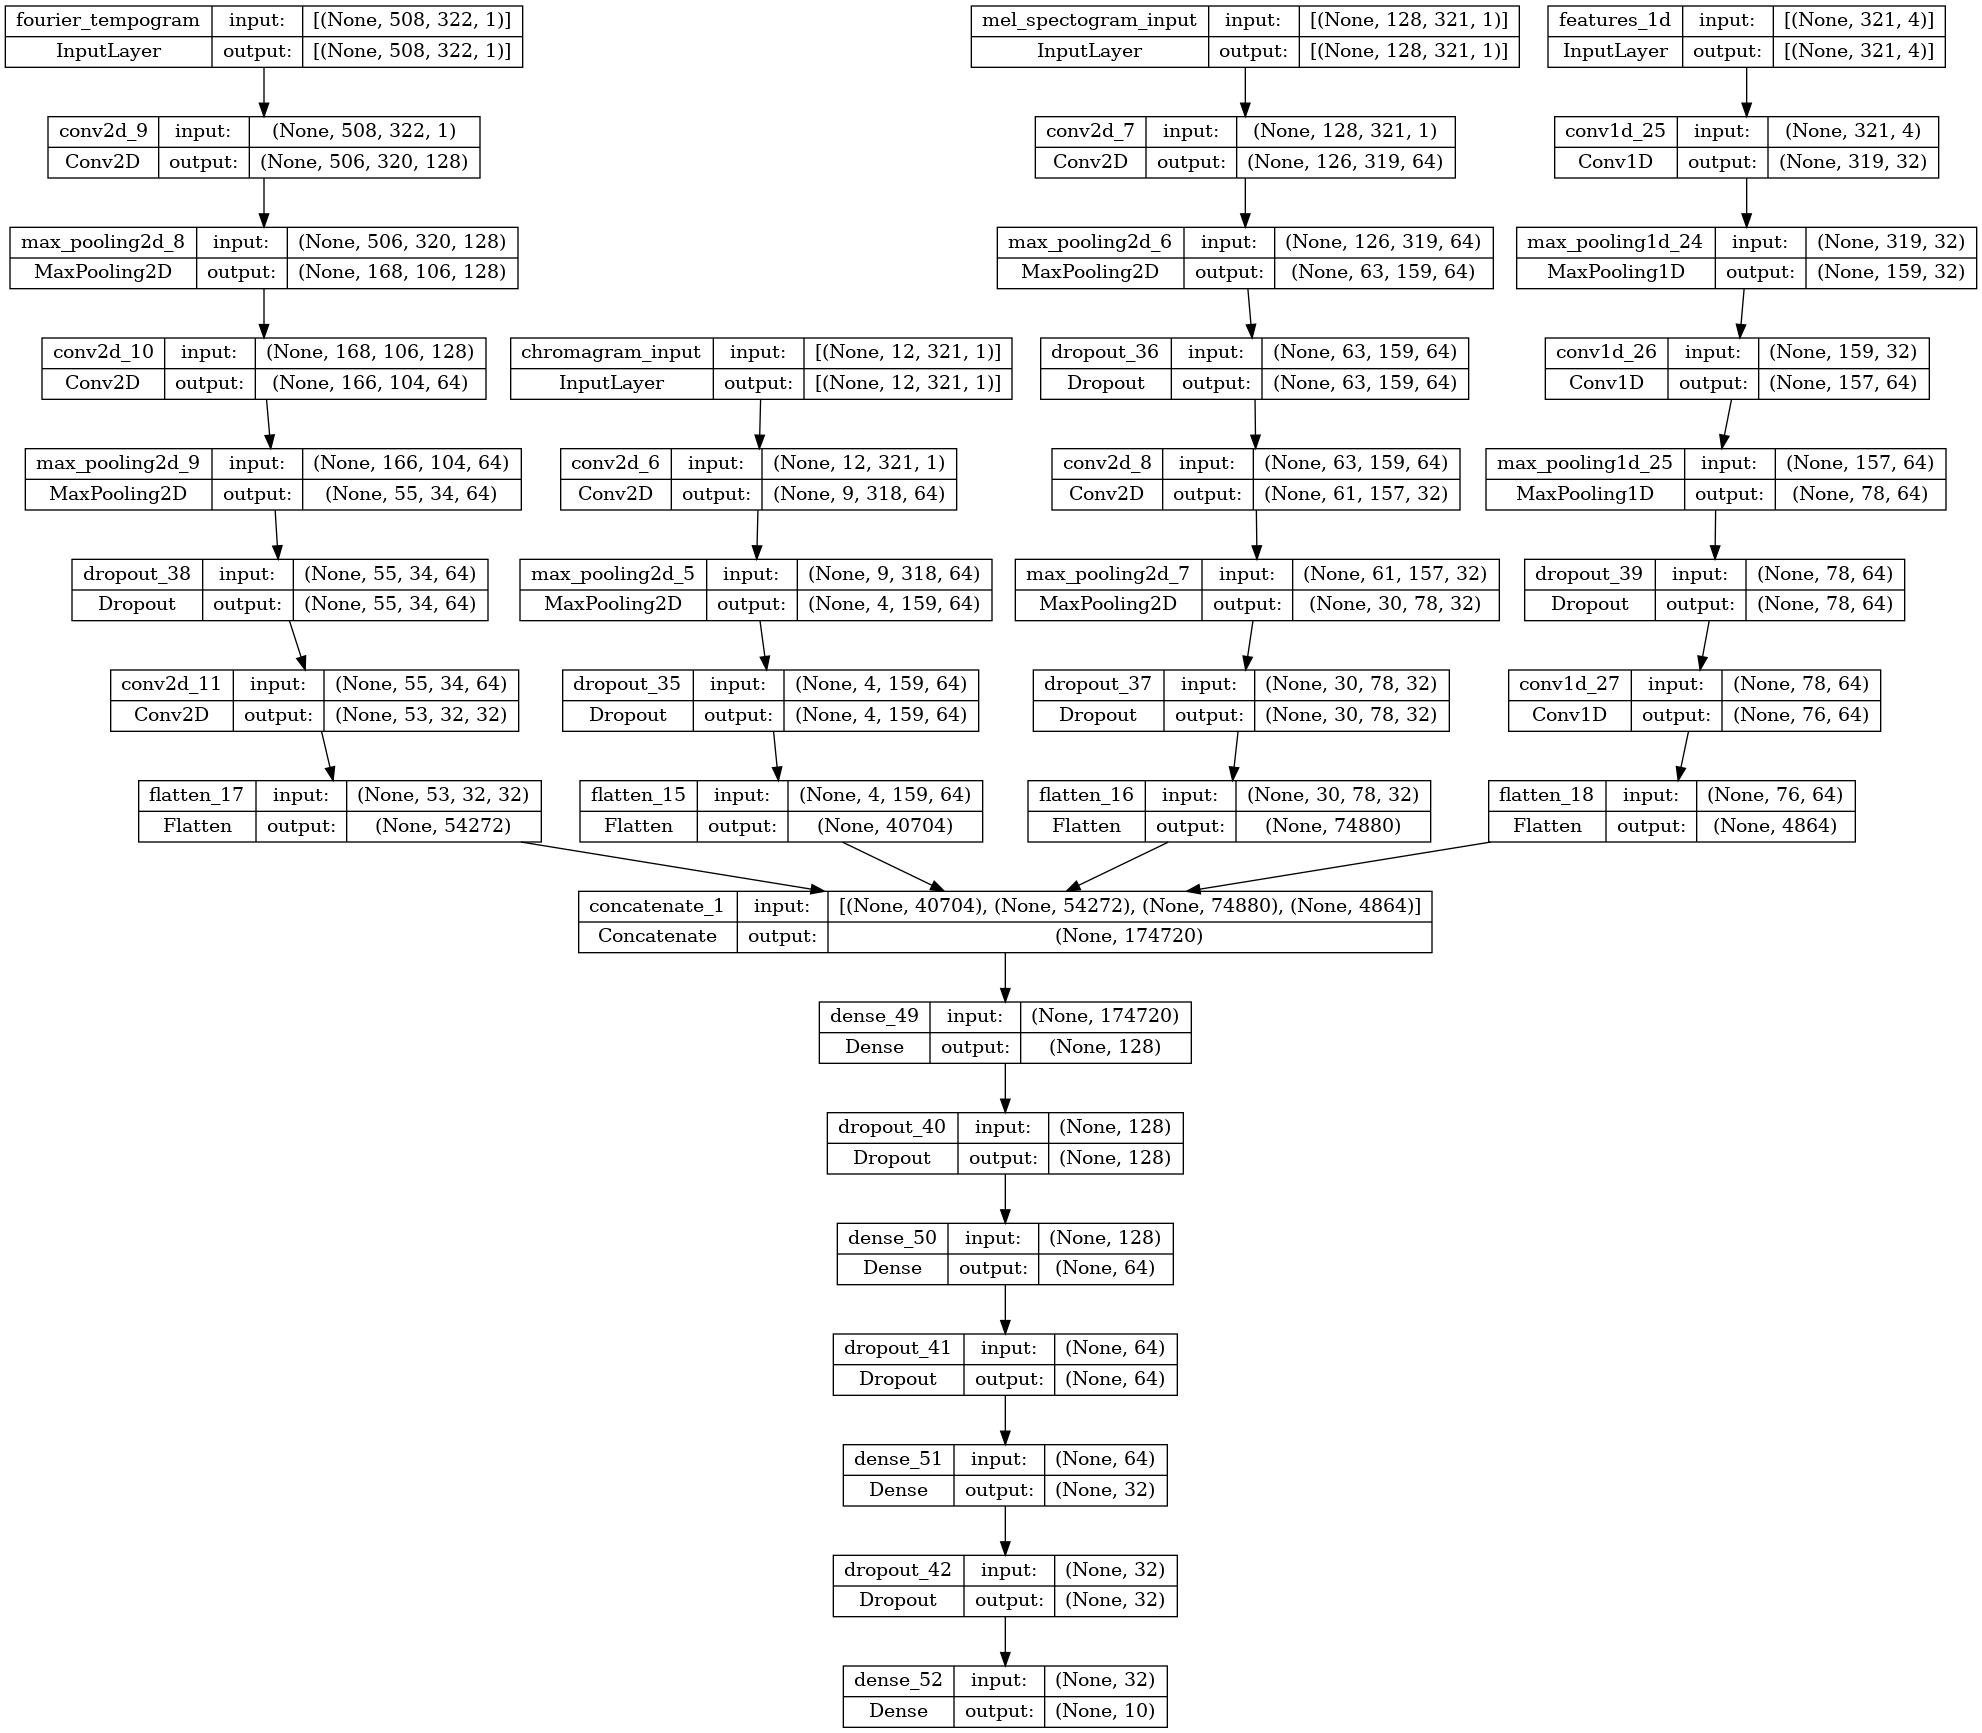

In [190]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [197]:
def kfold(n_folds, label_encoder, num_classes):
    accuracies = []
    conf_matrices = []
    all_histories = []

    for test_fold in range(1, n_folds + 1):
        X_train_list = [[] for _ in range(4)]  # Lista para armazenar os conjuntos de treinamento para cada tipo de entrada
        X_test_list = [[] for _ in range(4)]   # Lista para armazenar os conjuntos de teste para cada tipo de entrada
        y_train, y_test = [], []

        for fold in range(1, n_folds + 1):
            # Suponha que você tenha funções separadas para carregar cada tipo de característica
            chromagram, mel, tempogram, features_1d, labels = load_fold_data(fold, label_encoder)

            if fold == test_fold:
                for X_test, feature_set in zip(X_test_list, [chromagram, mel, tempogram, features_1d]):
                    X_test.append(feature_set)
                y_test = labels
            else:
                for X_train, feature_set in zip(X_train_list, [chromagram, mel, tempogram, features_1d]):
                    X_train.append(feature_set)
                y_train.extend(labels)

        # Concatenar e preparar os dados de treino e teste para cada tipo de entrada
        X_train_list = [np.concatenate(features, axis=0) for features in X_train_list]
        X_test_list = [np.array(features) for features in X_test_list]
        y_train = np.array(y_train)
        y_test = np.array(y_test)

        # Normalizar os dados de entrada (se necessário)
        # ...

        # Conversão para formato categórico
        y_train_categorical = to_categorical(y_train, num_classes)
        y_test_categorical = to_categorical(y_test, num_classes)

        # Treinar o modelo
        hist = model.fit(
            X_train_list, y_train_categorical,
            epochs=10, batch_size=32,
            validation_data=(X_test_list, y_test_categorical),
            verbose=0
        )
        all_histories.append(hist.history)

        # Avaliação do modelo
        test_loss, test_accuracy = model.evaluate(X_test_list, y_test_categorical, verbose=0)
        accuracies.append(test_accuracy)

        # Previsão e matriz de confusão
        y_pred = model.predict(X_test_list, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_categorical, axis=1)
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        conf_matrices.append(conf_mat)

    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print("Matriz de Confusão Média:\n", mean_conf_matrix)
    print(f"Acurácia média: {mean_accuracy:.2f}, Desvio padrão: {std_accuracy:.2f}")

    return all_histories, mean_conf_matrix, mean_accuracy, std_accuracy


In [198]:
n_folds = 10
accuracies = []
conf_matrices = []
all_histories = []

label_encoder = create_label_mapping(FOLDS_PATH, n_folds)

all_histories, mean_conf_matrix, mean_accuracy, std_accuracy=kfold(10,label_encoder,10)

TypeError: load_fold_data() missing 1 required positional argument: 'label_encoder'